In [1]:
## Import dependencies - pyscopg2 is a Python-PostgreSQL database adapter 

import psycopg2
import pandas as pd

In [2]:
# Establish connection to PostgreSQL database 

conn = psycopg2.connect(
    host="localhost",
    database="user_session",
    user="postgres",
    password="AAA009wn73ed")

conn.autocommit = True

In [3]:
# The curosor class allows Python code to execute PostgreSQL commands in a database session

cursor = conn.cursor()

In [4]:
# Create SQL query to select all data from an existing PostgreSQL table within the user_session database

selectQuery = ('''SELECT * FROM customer_session_data''')

# Execute the database operation through cursor.execute 

cursor.execute(selectQuery)

# cursor.fetchall returns all the records within the table, assign results to DataFrame & set column headers

userSession_Data =  pd.DataFrame(cursor.fetchall(), 
                                 columns=['Session Timestamp', 'Event Type', 'Product ID', 
                                          'Category ID', 'Category Code', 'Brand', 
                                          'Price', 'User ID', 'User Session ID'])

# Print first 5 rows of DataFrame by using ['DataFrame'].head() to check the data 

userSession_Data.head()

,Session Timestamp,Event Type,Product ID,Category ID,Category Code,Brand,Price,User ID,User Session ID
0,2019-01-10,view,44600062,2.10381E+18,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-01-10,view,3900821,2.05301E+18,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-01-10,view,17200506,2.05301E+18,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-01-10,view,1307067,2.05301E+18,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-01-10,view,1004237,2.05301E+18,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [5]:
# Check number of rows & columns by using ['DataFrame'].shape method:

# 1,048,575 ROWS
# 9 COLUMNS 

userSession_Data.shape

(1048575, 9)

In [6]:
# Check data types in each column of the DataFrame with the ['DataFrame'].dtypes method 

userSession_Data.dtypes

Session Timestamp    datetime64[ns]
Event Type                   object
Product ID                    int64
Category ID                  object
Category Code                object
Brand                        object
Price                       float64
User ID                       int64
User Session ID              object
dtype: object

In [7]:
## Split Category Code column into multiple columns based on '.' delimiter. 
# There are multiple levels of category within the data, but they are separated by full stops in the Category Code column
# Splitting the column into multiple category levels increases granularity of the data 


# Create 3 new columns to hold each Category Code Level & split the Category Code column based on the '.' delimiter
# Where Category Codes do not have additional categories, 'None' is returned 

userSession_Data[['Category Code L1', 'Category Code L2', 'Category Code L3']] = userSession_Data['Category Code'].str.split('.', n=2, expand=True)


userSession_Data = userSession_Data.drop(['Category Code'], axis=1)


In [8]:
## Capitalize each string within the DataFrame, as they have been presented all in lower case

# Apply a lambda function to each value in the DataFrame to capitalize the first letter 
# The function converts the dtype to string and applies the capitalize argument 
userSession_Data = userSession_Data.apply(lambda x: x.astype(str).str.capitalize())

# Print results 
userSession_Data.head()

,Session Timestamp,Event Type,Product ID,Category ID,Brand,Price,User ID,User Session ID,Category Code L1,Category Code L2,Category Code L3
0,2019-01-10 00:00:00,View,44600062,2.10381e+18,Shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,Nan,Nan,Nan
1,2019-01-10 00:00:00,View,3900821,2.05301e+18,Aqua,33.2,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,Appliances,Environment,Water_heater
2,2019-01-10 00:00:00,View,17200506,2.05301e+18,Nan,543.1,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,Furniture,Living_room,Sofa
3,2019-01-10 00:00:00,View,1307067,2.05301e+18,Lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,Computers,Notebook,Nan
4,2019-01-10 00:00:00,View,1004237,2.05301e+18,Apple,1081.98,535871217,C6bd7419-2748-4c56-95b4-8cec9ff8b80d,Electronics,Smartphone,Nan


In [9]:
## Calculate sales metrics for the website

# Use .loc to filter Event Type column for Purchase and sum the Price column

salesData = userSession_Data.loc[userSession_Data['Event Type'] == 'Purchase', ['Price']].sum(axis=1)

# Create DataFrame to hold cumulative sum of all purchases, create column named Total Sales Revenue

salesDataFrame = pd.DataFrame([salesData.sum()], columns=['Total Sales Revenue'])

# Create four new columns to display the following data:
# Total Sales Volume - Calculated with .size, returns length of a series 
# Median Price - Calculated with .median, returns median of a series
# Average Price - Calculated with.mean, retruns avg of a series 
# Total Web Traffic - Calculated using length of indexc in userSession_Data DataFrame

salesDataFrame[['Total Sales Volume', 'Median Price', 
   'Average Price', 'Total Web Traffic']] = pd.DataFrame([[salesData.size, salesData.median(), 
                                                           salesData.mean(), len(userSession_Data.index)]], 
                                                           index = salesDataFrame.index)


# Create one additional column to calculate sales conversion rate
# .div allows division sums between DataFrame columns 
# Total Sales Volume / Total Web Traffic = Sales Conversion Rate
salesDataFrame['Sales Conversion Rate'] = salesDataFrame['Total Sales Volume'].div(salesDataFrame['Total Web Traffic']) * 100

# To efficiently format the data (e.g $, %), a dictionary is created to hold the format for each column 
numberFormatting = {"Total Sales Revenue": "${:,.2f}", "Total Sales Volume": "{:,}", 
                  "Median Price": "${:,.2f}", "Average Price": "${:,.2f}", 
                  "Total Web Traffic":"{:,}", "Sales Conversion Rate": "{:.2f}%"}


# Apply style.format to the salesDataFrame
salesDataFrame = salesDataFrame.style.format(numberFormatting)

# Print results 
salesDataFrame


,Total Sales Revenue,Total Sales Volume,Median Price,Average Price,Total Web Traffic,Sales Conversion Rate
0,"$5,566,813.52","17,296",$185.08,$321.86,"1,048,575",1.65%


In [187]:
## Calculate times of the day with high and low relative user session volume 

import datetime as dt

# Count the number of events per each timeframe with the value_counts function, referencing Session Timestamp column
timeData = pd.DataFrame(userSession_Data.value_counts('Session Timestamp'), 
                  columns=['Count of Events']).reset_index()


plotData = timeData.sort_values(by='Session Timestamp', ascending=True)

plotData['Session Timestamp'] = pd.to_datetime(plotData['Session Timestamp'])

# plotData.plot(x='Session Timestamp', y='Count of Events', figsize=(12,4))

Session Timestamp    datetime64[ns]
Count of Events               int64
Timestamp                    object
dtype: object

<AxesSubplot:xlabel='Session Timestamp'>

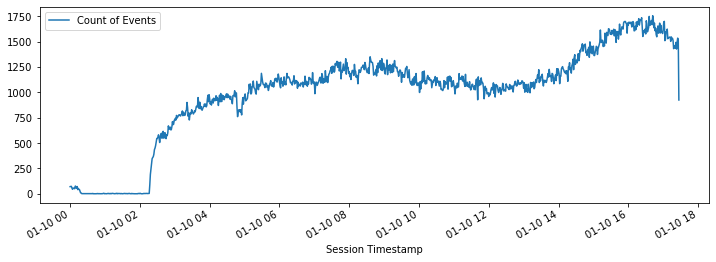

In [190]:
plotData.plot(x='Session Timestamp', y='Count of Events', figsize=(12,4))

In [11]:
## Calculate instances of each Event Type: View, Purchase & Cart 
# This data can be used to calculate the overall conversion rate of the website

# Create new DataFrame and use the .value_counts method to count the instances of each unique Event Type
eventTypes = pd.DataFrame(userSession_Data.value_counts('Event Type'), columns=['Count of Events']).reset_index()

# Print results 
eventTypes

,Event Type,Count of Events
0,View,1016239
1,Purchase,17296
2,Cart,15040


In [12]:
## Calculate total number of events (all categories) per brand

brandVolume = pd.DataFrame(userSession_Data.value_counts('Brand'), columns=['Count of Events']).reset_index()

# Replace Nan where no the product is unbranded with new tag - 'Unbranded'

brandVolume = brandVolume.replace("Nan", "Unbranded")

# Print Results 
brandVolume

,Brand,Count of Events
0,Unbranded,155682
1,Samsung,126027
2,Apple,107634
3,Xiaomi,72507
4,Huawei,29360
...,...,...
2240,Lava,1
2241,Mstar,1
2242,Musclepharm,1
2243,Floresan,1


In [13]:
## Calculate brands with the highest purchase volume 

# groupby Brand and Event Type and use size() which returns the number of elements within an object 
# Create a new DataFrame which will show the count of each event type per unique brand name

brandEventData = pd.DataFrame(userSession_Data.groupby(["Brand", "Event Type"]).size(),
                              columns=['Count of Events']).reset_index()

## Filter the Event Type column for 'purchase' using .loc, assign to variable named brandPurchaseData

brandPurchaseData = brandEventData.loc[brandEventData['Event Type'] == 'Purchase'] 

# Sort DataFrame from highest number of purchase events to lowest, print results 

brandPurchaseData.sort_values(by='Count of Events', ascending=False)

,Brand,Event Type,Count of Events
2393,Samsung,Purchase,4053
149,Apple,Purchase,3565
1897,Nan,Purchase,1388
2967,Xiaomi,Purchase,1337
1271,Huawei,Purchase,617
...,...,...,...
1003,Forza,Purchase,1
2167,Polti,Purchase,1
1001,Forward,Purchase,1
996,Forlux,Purchase,1


In [14]:
# Count the instances of each category code by using the value_counts() method
# This will return the count of instances for each unique category code 

categoryCodes = pd.DataFrame(userSession_Data['Category Code L1'].value_counts()).reset_index()

# Rename columns following the index reset, as by default it will be renamed 'index' 

categoryCodes.columns = ['Category L1', 'Count of Events']

# Extract top 100 category codes, using nlargest & assigning 100 to 'n' - This number can be amended if required
# The below DataFrame displays the best performing category codes in terms of event count

topCategoryCodes = categoryCodes.nlargest(n=100, columns=['Count of Events'])